# Pupil analysis

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [208]:
f = '../behav_data/preproc/expressive/sub-lukas/sub-lukas_expressive.hdf5'
df = pd.read_hdf(f, 'expressive_1__1/block_0')
df = df.set_index('time')
df.index = df.index / 1000  # convert to seconds
start_recording = df.index[0]
df.index -= start_recording

0.0

In [3]:
msg_file = '../behav_data/preproc/expressive/sub-lukas/raw/expressive_1__1.msg' 
with open(msg_file, 'r') as msg:
    lines = msg.readlines()
    for i, line in enumerate(lines):
        
        if line[:6] == 'EVENTS':
            start = i
            break
    
msgs = [l for l in lines[start+1:] if 'MSG' in l]

In [215]:
trial_nr = 1
dfs = []
while True:
    these_msg = [l for l in msgs if 'trial %i ' % trial_nr in l]
    if not these_msg:
        break
    
    onset = float(these_msg[0].split('\t')[1]) / 1000 - start_recording
    info = {}
    these_msg = these_msg[1:-1]
    for msg in these_msg:
        tmp = msg.split('parameter\t')[1]
        info[tmp.split(' : ')[0]] = tmp.split(' : ')[1].replace('\n', '')
    dfs.append(pd.DataFrame(info, index=[onset]))
    trial_nr += 1
        
events = pd.concat(dfs)
for col in events.columns:
    events[col] = pd.to_numeric(events[col], errors='ignore')

Als numeric: zet NaN op 0.

In [218]:
concat = pd.concat((df, events), axis=1)
for col in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[col]):
        concat[col] = concat[col].fillna(0)

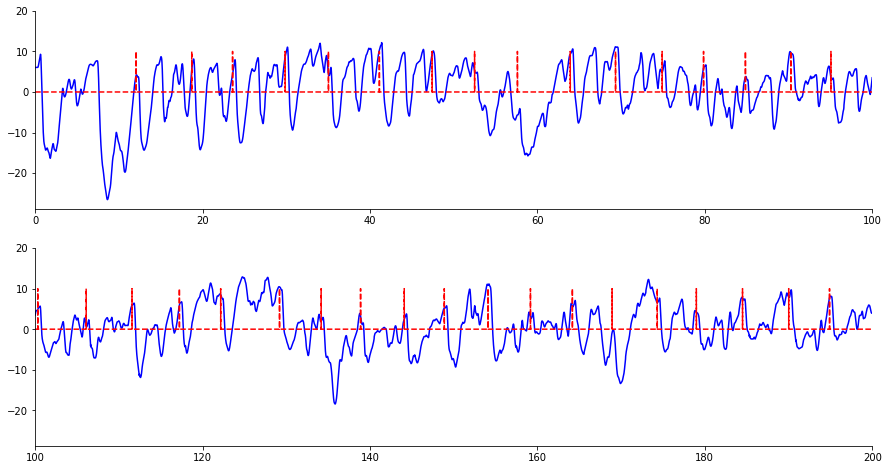

In [222]:
fig, ax = plt.subplots(nrows=2, sharex=False, sharey=True, figsize=(15, 8))
ax[0].plot(concat.R_pupil_bp_clean_psc, c='b')
ax[0].plot(concat.index, [10 if pd.notna(t) else 0 for t in concat.trial_type], c='r', ls='--')
ax[0].set_xlim(0, concat.index.tolist()[100000])

ax[1].plot(concat.R_pupil_bp_clean_psc, c='b')
ax[1].plot(concat.index, [10 if pd.notna(t) else 0 for t in concat.trial_type], c='r', ls='--')
ax[1].set_xlim(concat.index.tolist()[100000], concat.index.tolist()[200000])

sns.despine()

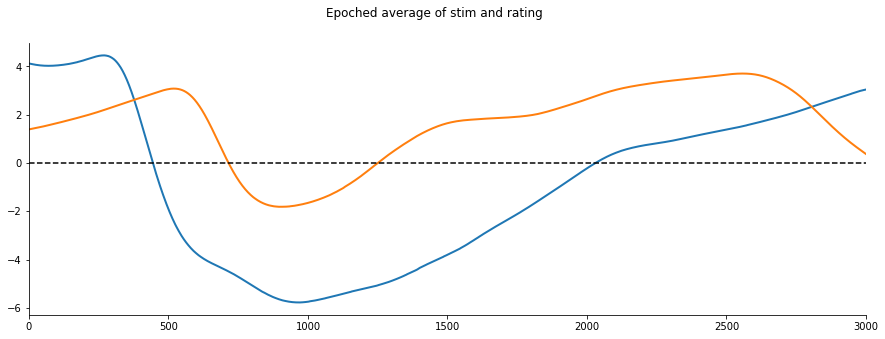

In [58]:
import nideconv

fig, ax = plt.subplots(figsize=(15, 5))
rf = nideconv.ResponseFitter(input_signal=concat.R_pupil_bp_clean_psc,
                             sample_rate=1000,
                             oversample_design_matrix=1)

stim_epochs = rf.get_epochs(onsets=events.index, interval=[0, 3])
ax.plot(stim_epochs.mean().values, lw=2, alpha=1.0)

rating_epochs = rf.get_epochs(onsets=events.index + 2.5, interval=[0, 3])
ax.plot(rating_epochs.mean().values, lw=2, alpha=1.0)
ax.set_xlim(0, 3000)
ax.axhline(0, ls='--', c='k')
fig.suptitle('Epoched average of stim and rating')
sns.despine()

/Users/lukas/anaconda3/lib/python3.6/site-packages/nideconv-0.1.dev0-py3.6.egg/nideconv/regressors.py:194: UserWarning: 
Interval is now automatically set to [0. 3.].
  warnings.warn(warning)


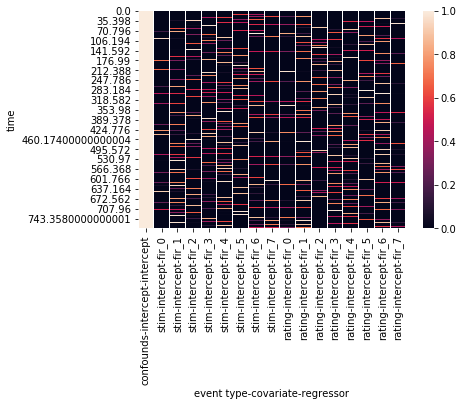

In [224]:
rf = nideconv.ResponseFitter(input_signal=concat.R_pupil_bp_clean_psc,
                             sample_rate=1000,
                             oversample_design_matrix=1)

rf.add_event(event_name='stim',
             onset_times=events.index,
             interval=[0., 3.],
             n_regressors=8,
             basis_set='fir')

rf.add_event(event_name='rating',
             onset_times=events.index + 2.5,
             interval=[0., 3.],
             n_regressors=8,
             basis_set='fir')

sns.heatmap(rf.X);

/Users/lukas/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


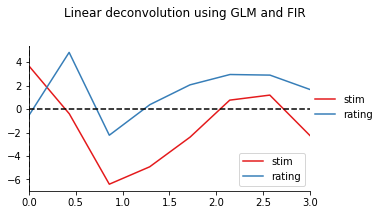

In [226]:
rf.regress()
sns.set_palette(palette)
rf.plot_timecourses()
plt.suptitle('Linear deconvolution using GLM and FIR')
plt.title('')
plt.legend()

### Fourier

/Users/lukas/anaconda3/lib/python3.6/site-packages/nideconv-0.1.dev0-py3.6.egg/nideconv/regressors.py:194: UserWarning: 
Interval is now automatically set to [0.  1.5].
  warnings.warn(warning)
/Users/lukas/anaconda3/lib/python3.6/site-packages/nideconv-0.1.dev0-py3.6.egg/nideconv/regressors.py:224: UserWarning: Number of fourier regressors has to be uneven and has automatically been set to 5 per covariate
  'been set to {} per covariate'.format(self.basis_set, self.n_regressors))


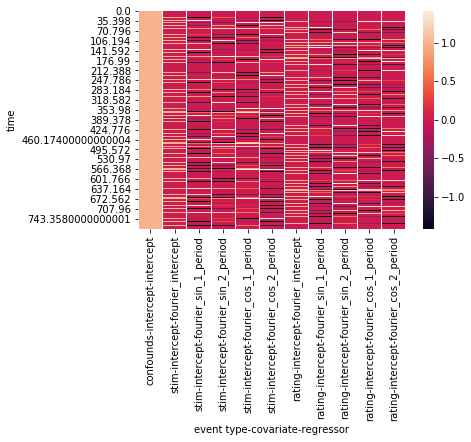

In [65]:
rf = nideconv.ResponseFitter(input_signal=concat.R_pupil_bp_clean_psc,
                             sample_rate=1000,
                             oversample_design_matrix=1)

rf.add_event(event_name='stim',
             onset_times=events.index,
             interval=[0., 1.5],
             n_regressors=4,
             basis_set='fourier')

rf.add_event(event_name='rating',
             onset_times=events.index + 2.5,
             interval=[0., 1.5],
             n_regressors=4,
             basis_set='fourier')

sns.heatmap(rf.X)

/Users/lukas/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


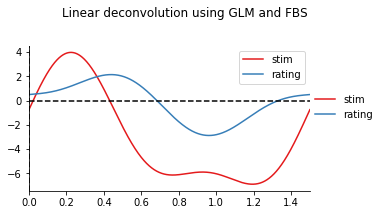

In [66]:
rf.regress()
sns.set_palette(palette)
rf.plot_timecourses()
plt.suptitle('Linear deconvolution using GLM and FBS')
plt.title('')
plt.legend()

pupil irf:
- ISI = 1.25 sec + exponential(mean = 2) 
- blink pause

/Users/lukas/anaconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/Users/lukas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


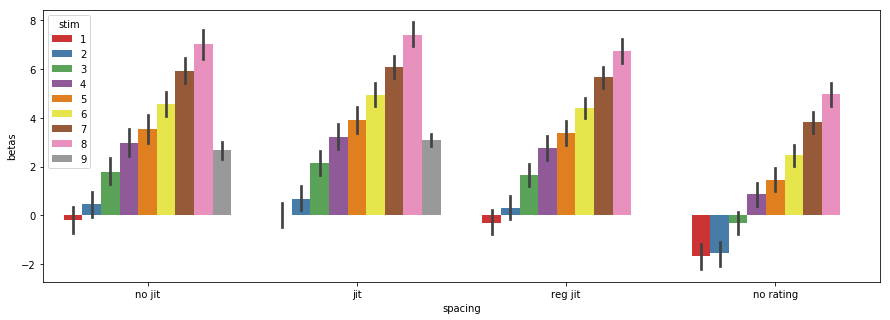

In [205]:
from nistats.hemodynamic_models import glover_hrf

N_stim = 8
T = 100
ITI = int(T / N_stim)
oversampling = 10
hrf = glover_hrf(tr=1, oversampling=oversampling)
iters = 200

results = dict(betas=[], spacing=[], stim=[])
for itr in range(iters):
    stims = np.zeros((N_stim, (T + 10)*oversampling ))
    ratings = np.zeros((T + 10)*oversampling)
    ratings_jit = np.zeros((T + 10)*oversampling)

    for i in range(N_stim):
        onset_stim = i*ITI*oversampling 
        onset_rating = onset_stim + 5*oversampling
        onset_rating_jit = int(onset_stim + (2.5 + np.random.exponential(2.5))*oversampling)
        stims[i, onset_stim] = 1
        ratings[onset_rating] = 1
        ratings_jit[onset_rating_jit] = 1

    stims = np.hstack([np.convolve(hrf, stims[i, :])[:T*oversampling, np.newaxis] for i in range(N_stim)])
    ratings = np.convolve(hrf, ratings)[:T*oversampling]
    ratings_jit = np.convolve(hrf, ratings_jit)[:T*oversampling]
    
    betas_stims = np.arange(N_stim)
    beta_rating = 3
    noise = np.random.normal(0, .5, size=T*oversampling)
    y = stims.dot(betas_stims) + ratings*beta_rating + noise 
    y_jit = stims.dot(betas_stims) + ratings_jit*beta_rating + noise

    betas = np.linalg.lstsq(np.c_[np.ones(ratings.size), stims, ratings], y, rcond=None)[0][1:]
    results['betas'].extend(betas)
    results['spacing'].extend(['no jit']*len(betas))
    results['stim'].extend(np.arange(1, len(betas)+1))
    
    betas = np.linalg.lstsq(np.c_[np.ones(ratings.size), stims, ratings_jit], y_jit, rcond=None)[0][1:]
    results['betas'].extend(betas)
    results['spacing'].extend(['jit']*len(betas))
    results['stim'].extend(np.arange(1, len(betas)+1))
    
    des = np.c_[np.ones(ratings.size), ratings_jit]
    y_jit -= des.dot(np.linalg.lstsq(des, y_jit)[0])
    betas = np.linalg.lstsq(np.c_[np.ones(ratings.size), stims], y_jit, rcond=None)[0][1:]
    results['betas'].extend(betas)
    results['spacing'].extend(['reg jit']*len(betas))
    results['stim'].extend(np.arange(1, len(betas)+1))

    betas = np.linalg.lstsq(np.c_[np.ones(ratings.size), stims], y, rcond=None)[0][1:]
    results['betas'].extend(betas)
    results['spacing'].extend(['no rating']*len(betas))
    results['stim'].extend(np.arange(1, len(betas)+1))

df = pd.DataFrame(results)
plt.figure(figsize=(15, 5))
sns.barplot(data=df, x='spacing', y='betas', hue='stim')